
# Сравнение алгоритмов кластеризации на искусственных наборах данных

Эти примеры демонстрируют свойства различных алгоритмов кластеризации на наборах данных, структура которых "интересна" с точки зрения возможности верного разделения на кластеры, но лишь двумерные. Для каждого алгоритма на каждом наборе данных были выбраны параметры, которые позволяют получить хорошие результаты. О том, как выбрать такие параметры, речь пойдет в другой тетрадке. 

Представленный в данной тетрадке код является модификацией примера из sklearn: http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html

In [29]:
import time # эта бибилиотека нам понадобится для оценки времени работы алгоритма
import warnings

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Для начала сгенерируем 6 наборов двумерных данных специального вида с метками кластеров.

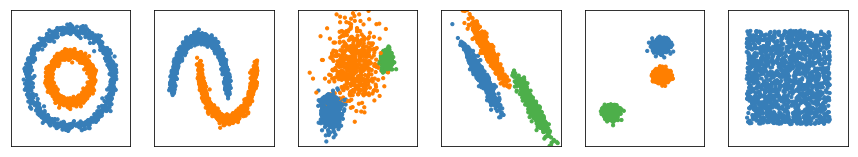

In [27]:
from sklearn.datasets import make_circles, make_moons, make_blobs
from sklearn.preprocessing import StandardScaler
np.random.seed(0)

n_samples = 1500
noisy_circles = make_circles(n_samples=n_samples, factor=.5, # две концентрических окружности с шумом
                                      noise=.05)
noisy_moons = make_moons(n_samples=n_samples, noise=.05) # две "луны" с шумом ("два рогалика")
blobs = make_blobs(n_samples=n_samples, random_state=8) # три примерно одинаковых "пятна" круглой формы
no_structure = (np.random.rand(n_samples, 2), np.array([0]*n_samples)) # случайные точки без структуры

# три элиптических "пятна"
random_state = 170
X, y = make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# три "пятна" с разной дисперсией
varied = make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

datasets = [noisy_circles, noisy_moons, varied, aniso, blobs, no_structure]

colors = np.array(['#377eb8', '#ff7f00', '#4daf4a'])

# изобразим эти датасеты на графиках
plt.figure(figsize=(6*2 + 3, 2.5))
for i, ds in enumerate(datasets):
    X, y = ds
    X = StandardScaler().fit_transform(X) #стандартизируем данные
    plt.subplot(1, len(datasets), i+1)
    plt.scatter(X[:, 0], X[:, 1], c=colors[y], s=10)

    plt.xlim(-2.5, 2.5)
    plt.ylim(-2.5, 2.5)
    plt.xticks(())
    plt.yticks(())
    
plt.show()

Зададим параметры для алгоритмов кластеризации.

In [28]:
# параметры по умолчанию для всех алгоритмов
default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3}

# специйикация некоторых параметров для каждого набора данных
datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2}),
    (aniso, {'eps': .15, 'n_neighbors': 2}),
    (blobs, {}),
    (no_structure, {})]

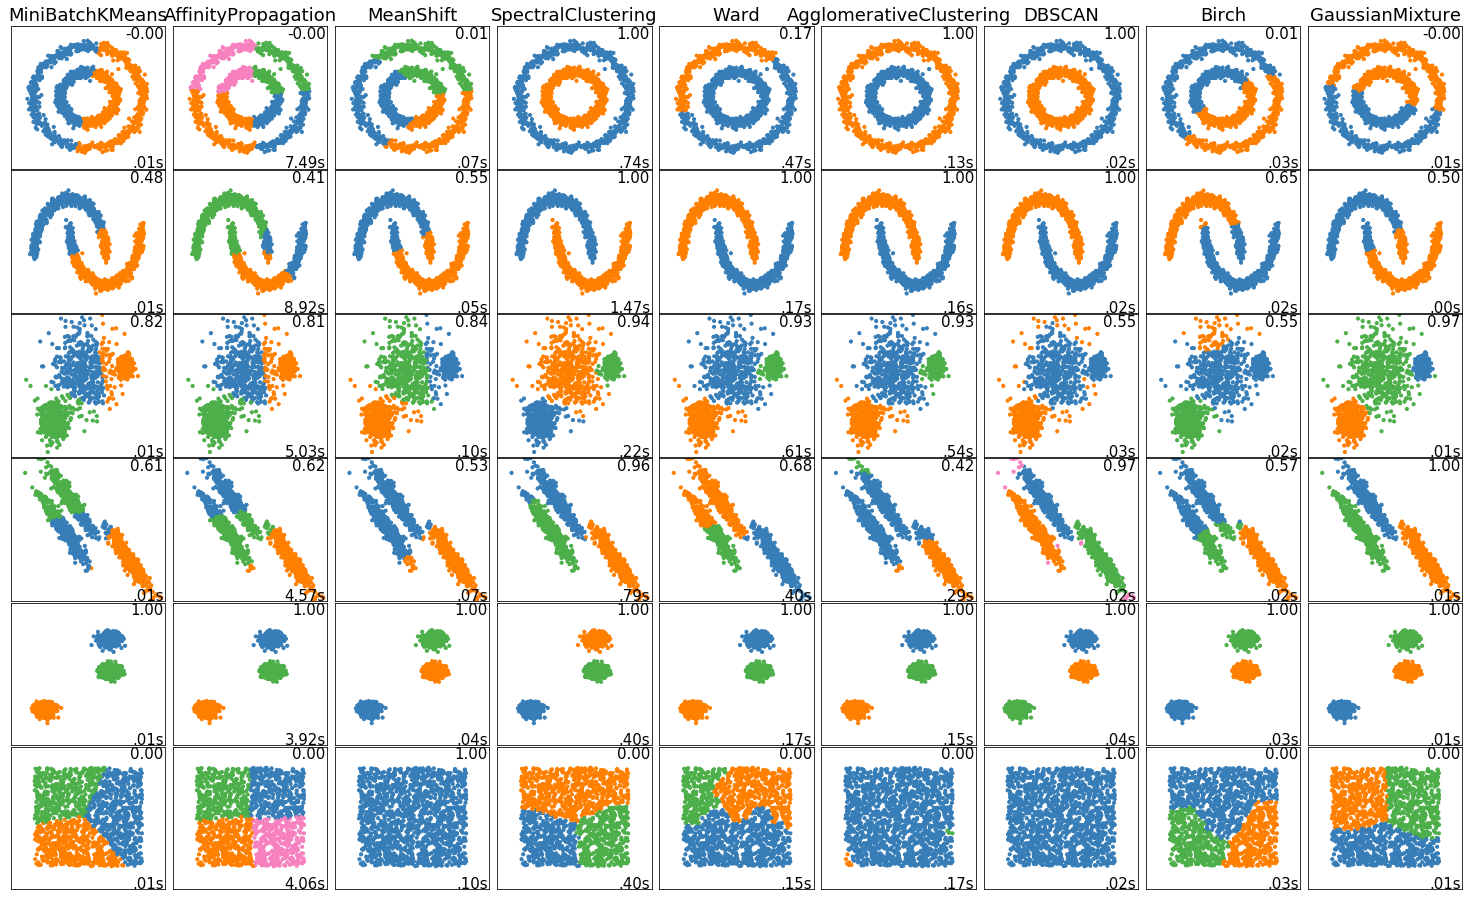

In [34]:
from sklearn import cluster, mixture
from sklearn.neighbors import kneighbors_graph
from itertools import cycle, islice
from sklearn.metrics import adjusted_rand_score

# результаты кластеризации отобразим в качестве набора графиков 
# (количество наборов данных * количество алгоритмов для сравнения)
plt.figure(figsize=(9 * 2 + 3, 12.5)) # задаим размеры изображения
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01) # зададим отступы границы графиков от краев изображения и между собой

plot_num = 1

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    
    params = default_base.copy()
    params.update(algo_params) # ищменяем базовые параметры, если того требует спецификация параметров для набора данных

    X, y = dataset
    
    X = StandardScaler().fit_transform(X) #стандартизируем данные
    
    # оценим ширину окна для алгоритма Mean Shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # построим матрицу связности вершин с весами
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # n_neighbors - число соседей, с которыми устанавливается связность
    # сделаем эту матрицу симметричной
    connectivity = 0.5 * (connectivity + connectivity.T)

    # Создаем объекты, соответствующие алгоритмам кластеризации
    
    # Mean Shift с оцененной выше шириной окна
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    
    # K-средних с обучением по неболшим подвыборкам на каждом шаге
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    
    # Агломеративная кластеризация с минимизацией дисперсии внутри кластеров
    # помимо прочего, подаем на взод матрицу связности
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    
    # Спектральная класетризация со сходством на основе ближайших соседей
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    
    # DBSCAN
    dbscan = cluster.DBSCAN(eps=params['eps'])
    
    # Afinity propagation
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'])
    
    # Агломеративная кластеризация при минимизации среднего расстояния между парой точек в кластере
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    
    # Birch
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    
    # Восстановление смеси нормальных распределений
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')

    # поместим все созданные объекты в словарь с ключам, соответствующими названию алгоритмов
    clustering_algorithms = (
        ('MiniBatchKMeans', two_means),
        ('AffinityPropagation', affinity_propagation),
        ('MeanShift', ms),
        ('SpectralClustering', spectral),
        ('Ward', ward),
        ('AgglomerativeClustering', average_linkage),
        ('DBSCAN', dbscan),
        ('Birch', birch),
        ('GaussianMixture', gmm)
    )

    # пройдем по всем алгоритмам
    for name, algorithm in clustering_algorithms:
        t0 = time.time() # зафиксируем время начала работы текущего алгоритма

        # отследим предупреждения, возникающие из-за проблем с графом связности
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X) # обучим текущий алгоритм

        t1 = time.time() # зафиксируем время окончания работы алгоритма
        if hasattr(algorithm, 'labels_'): # если у объекта есть атрибут labels_ - назначенные метки класера
            y_pred = algorithm.labels_.astype(np.int) # считаем их предсказанием
        else:
            y_pred = algorithm.predict(X) # иначе применяем метод predict для получения предсказаний

        
        # выбираем текущую позицию в сетке графиков данные*алгоритм
        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        
        if i_dataset == 0: # Для графиков в верхней строке подписывае названия алгоритма
            plt.title(name, size=15)
        
        # задаем набор цветов для отображения кластеров
        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right') # в правом нижнем углу каждого графика подписываем время обучения
        
        plt.text(.99, .92, ('%.2f' % adjusted_rand_score(y, y_pred)),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right') # в правом верхнем углу - adjusted_rand_index
        plot_num += 1

plt.show()